In [1]:
import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
import Hardmodel
importlib.reload(Hardmodel)
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools

import helpers.fit_functions 
importlib.reload(helpers.fit_functions)
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.758407321767532
3.474289087241136


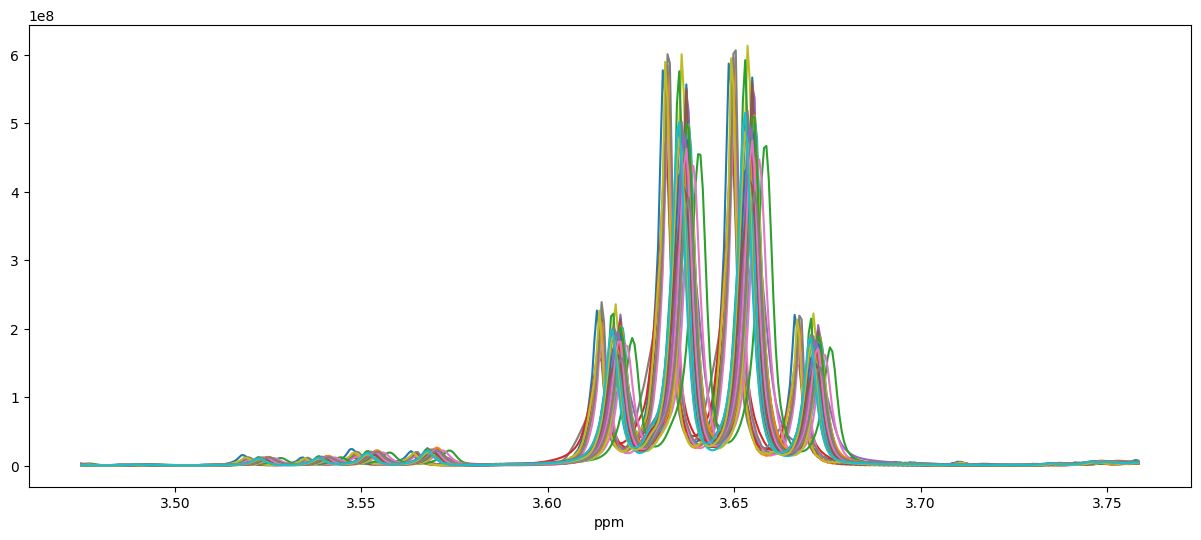

In [2]:
# 3.5-3.7
si = 3550
ei = 4000
#3.5-3.6
# si = 3800
# ei = 4000
#

print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]
plt.figure(figsize=(15,6))
plt.plot(ppm,X.T)
plt.xlabel("ppm")
plt.show()

epoch: 1000, Loss: 0.03940551186608458, Tau: 1322.3698423663483


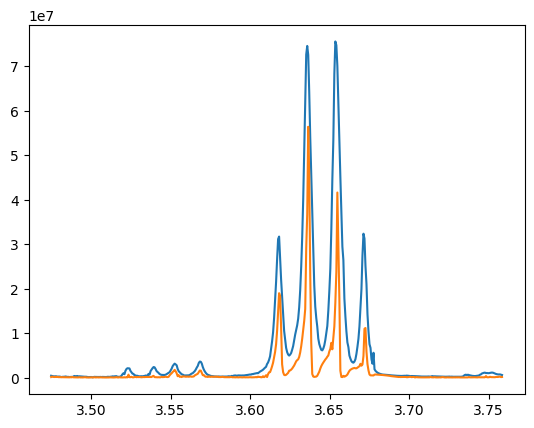

In [3]:

nmf = ShiftNMF(X, 2, lr=0.1, alpha=1e-6, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


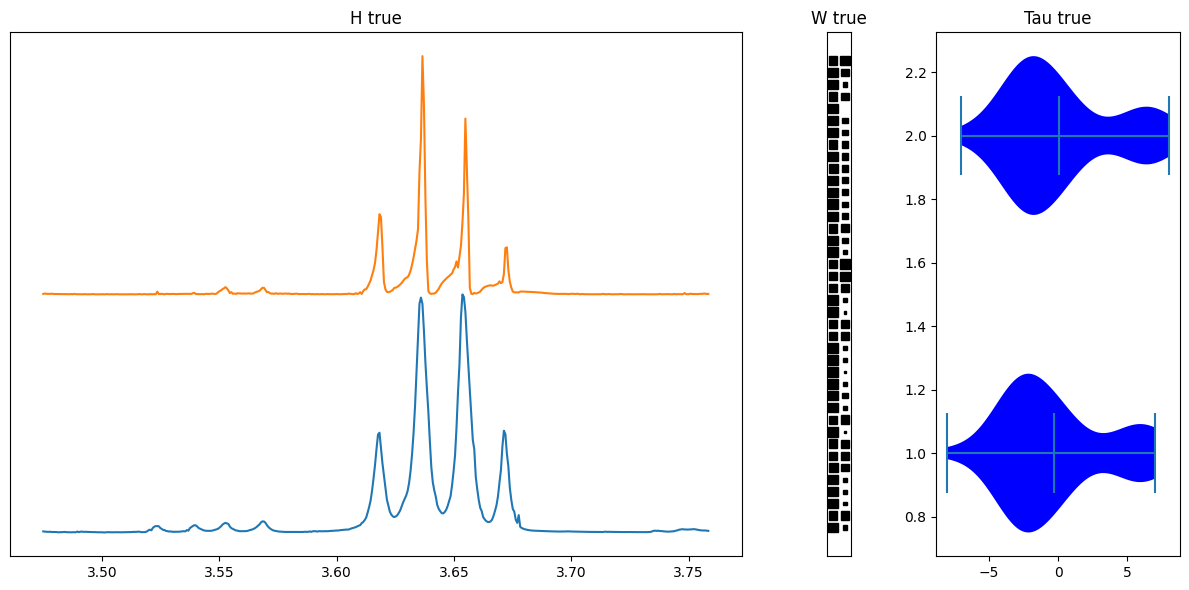

In [4]:
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X[:,0:3000].shape
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

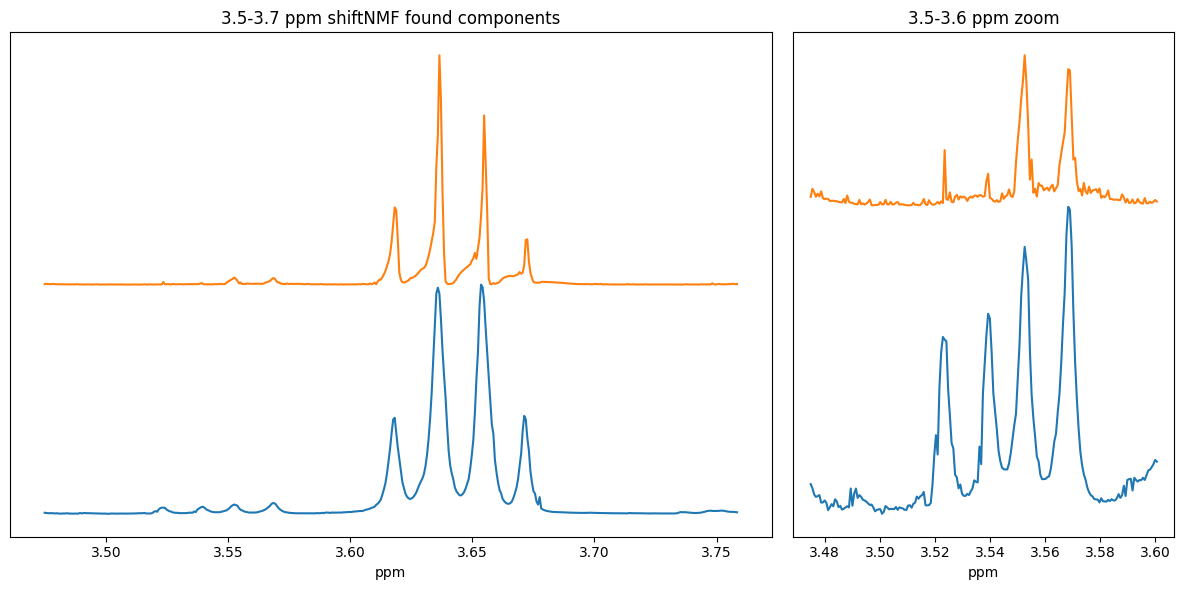

In [5]:
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

fig = plt.figure(figsize=(12, 6))
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('3.5-3.7 ppm shiftNMF found components')
ax1.set_xlabel("ppm")

ax2 = plt.subplot(gs[1])
ax2.set_title('3.5-3.6 ppm zoom')
plotSpaced(ax2, ppm[250:],H_est[:,250:].T)
ax2.set_xlabel("ppm")


# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()


# Hardmodel

In [6]:
from helpers.plot import *
fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []
losses = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.1, min_sigma=1, lr=0.1 , plot=False)
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas, loss = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    losses.append(loss)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(ppm,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(ppm,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

Found peaks:[ 10  17 138 166 194 222 301 326 347 373]
sigma: 19.773299276150375 n:0.9999492843439328
sigma: 5.386758032077697 n:1.9411678979434208e-08
sigma: 5.93016151781339 n:0.8726892920156626
sigma: 9.373114275409293 n:1.991158413644379e-07
sigma: 9.243629422421915 n:1.1025059735495238e-06
sigma: 7.679008201318018 n:0.743181591671312
sigma: 7.091030340866233 n:0.9443388722267068
sigma: 7.115640106950654 n:0.859978736001342
sigma: 6.514710714112168 n:0.8360471533038119
sigma: 6.65910344641024 n:0.8365808160271275
Lorentzian %:s: 0.033868636141054564
tensor([9.9997e-01, 1.9412e-08, 8.4709e-01, 1.6805e-07, 6.4493e-07, 7.8347e-01,
        9.8512e-01, 9.5579e-01, 9.3257e-01, 9.4861e-01],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([21.2962,  5.1837,  6.2226,  9.5136,  9.3295,  7.7674,  8.4100,  8.2817,
         7.4626,  7.7894], requires_grad=True)
hypothesises:
{(2, 5, 6, 8), (1, 3, 5, 7, 8, 9), (0, 1, 2, 8), (0, 3, 4, 5, 7, 9), (1, 2, 3, 4, 6, 8, 9), (0, 1, 

c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=4.32787e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=9.27254e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=8.99311e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=7.07074e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=5.87626e-09): result may not be accurate.
  w = solve(XtX[np.

epoch: 1, Loss: 0.024819440761520664
epoch: 2, Loss: 0.024819440761520664
means:
[152.      163.16667 180.      166.      194.11111]
sigmas:
[7.8681026 9.68146   8.20829   7.776079  9.310468 ]
J coupling:
[28.  7. 28. 56.  7.]
multiplicity
[2 6 4 2 9]
N
[0.00096396 0.08219638 0.00121259 0.00188665 0.06441025]
W:
[[0. 0. 0. ... 0. 0. 0.]]
Found peaks:[126 136 147 164 170 193 222 301 326 372]


In [19]:

for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regularization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(ppm, H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")

   
    sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = 5

    for j in range(nr_of_components):
            ax1.plot(ppm,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    plt.tight_layout()
    plt.show()

NameError: name 'reg_paths' is not defined